In [2]:
# Import Libraries 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.pyplot
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd 
import datetime
import seaborn as sns
from matplotlib.pyplot import figure
sns.set_style("ticks")
sns.set_context("paper")
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Task II

#### Problem Statement

In the second task, the applicant is asked to code an algorithm for one-step prediction of future traffic in a single area. Formally, let us denote as $x_a$(t) the traffic observed at area _a_ during time interval _t_. At each time _t_, the algorithm receives as input a history $x_t$, ie., a vector of traffic values in past time intervals, upto _t_ included (the exact format of the history has to be selected by the applicant. The algorithm shall then produce as output an estimate $x_a$(t+1) of future _t+1_ in area _a_. The applicant shall run the algorithm to forecast traffic in the four geographical areas identified in Task I, during the week from December 16 to 22. 

#### Reading datafiles for December 2013 Call Detail Records (CDRs)

In [27]:
#Read Datafiles
df_cdrs_dec = pd.DataFrame({})
for i in range(1,23):
    df = pd.read_csv('../Data/CDRs_csv/sms-call-internet-mi-2013-12-%d.csv'%i , parse_dates=['datetime'])
    df_cdrs_dec = df_cdrs_dec.append(df)

df_cdrs_dec=df_cdrs_dec.fillna(0)   
df_cdrs_dec['sms'] = df_cdrs_dec['smsin'] + df_cdrs_dec['smsout']
df_cdrs_dec['calls'] = df_cdrs_dec['callin'] + df_cdrs_dec['callout']

In [28]:
df_cdrs_dec = df_cdrs_dec[['datetime', 'squareid', 'internet', 'sms', 'calls']].groupby(['datetime', 'squareid'], as_index=False).sum()

In [29]:
df_cdrs_dec.head()

,datetime,squareid,internet,sms,calls
0,2013-12-01 04:00:00,1,38.334986,0.998167,0.386405
1,2013-12-01 04:00:00,2,38.442747,1.001215,0.385027
2,2013-12-01 04:00:00,3,38.557454,1.004459,0.383559
3,2013-12-01 04:00:00,4,38.022854,0.989339,0.390399
4,2013-12-01 04:00:00,5,35.020609,0.950305,0.362042


In [30]:
df_cdrs_dec.tail()

,datetime,squareid,internet,sms,calls
5288541,2013-12-23 04:00:00,9996,99.674853,10.428193,2.226105
5288542,2013-12-23 04:00:00,9997,117.566723,9.832174,2.579503
5288543,2013-12-23 04:00:00,9998,114.246666,9.983915,2.511387
5288544,2013-12-23 04:00:00,9999,63.307139,9.257973,1.538561
5288545,2013-12-23 04:00:00,10000,51.480852,8.225620,1.331205


In [15]:
df_cdrs_dec['hour'] = df_cdrs_dec.datetime.dt.hour+24*(df_cdrs_dec.datetime.dt.day-1)
df_cdrs_dec = df_cdrs_dec.set_index(['hour']).sort_index()

#### Before directly jumping onto algorithm and modelling, First we will check Trend, Seasonality and Stationarity of our Time Series  

To check Trend, Seasonality, Stationarity and modeling of our Time Series, we are first considering the area with highest network traffic ie. **squareid 5161** 

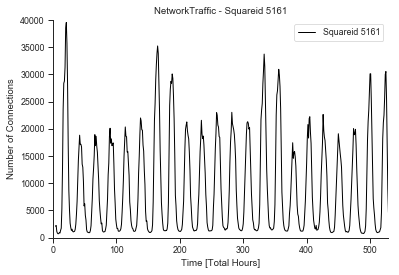

In [21]:
ydata = df_cdrs_dec[df_cdrs_dec.squareid==5161]['internet']
xdata = df_cdrs_dec[df_cdrs_dec.squareid==5161]['internet'].index

f = plt.figure()
plt.plot(xdata, ydata, color='black', linewidth=1, linestyle='-', label='Squareid 5161')
plt.title("NetworkTraffic - Squareid 5161")
plt.xlabel("Time [Total Hours]")
plt.ylabel("Number of Connections")
plt.xlim([0,528])
plt.ylim([0,40000])
plt.legend()
sns.despine()
plt.show()

From the above figure, we can see the periodic nature of the time series with total number of connections. By inspection, the period is ~24 hrs.  

#### Trend and Seasonality

In our case, we can see the daily seasonality (with no specific trend) which is consistent at every 24 hr period in the internet traffic activity. 

#### Stationary Series

#### Checking the Stationarity using Dickey-Fuller Test

#### Check whether internet network traffic is stationary or not

In [31]:
df = df_cdrs_dec.set_index(['datetime']).sort_index()

In [32]:
df_5161 = df.loc[df['squareid'] == 5161]

In [34]:
df_5161.head()

,squareid,internet,sms,calls
datetime,,,,
2013-12-01 04:00:00,5161,2092.510257,125.255055,60.742112
2013-12-01 05:00:00,5161,2210.605167,90.010635,43.629044
2013-12-01 06:00:00,5161,1087.450661,13.053315,22.721918
2013-12-01 07:00:00,5161,807.558327,13.080702,9.079012
2013-12-01 08:00:00,5161,676.222631,18.035036,16.445250


In [35]:
df_5161.tail()

,squareid,internet,sms,calls
datetime,,,,
2013-12-23 00:00:00,5161,8987.801230,1108.012576,1030.669120
2013-12-23 01:00:00,5161,4691.757804,473.155080,385.856175
2013-12-23 02:00:00,5161,3207.742705,222.585613,114.976503
2013-12-23 03:00:00,5161,2077.588679,111.594438,35.683362
2013-12-23 04:00:00,5161,765.280927,40.750974,18.787278


In [42]:
df_5161 = df_5161[['internet']]

In [45]:
TS_5161 = df_5161
TS_5161_index = df_5161.index

In [43]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = ydata.rolling(24).mean()
    rolstd = ydata.rolling(24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#### Run on Input Time Series 

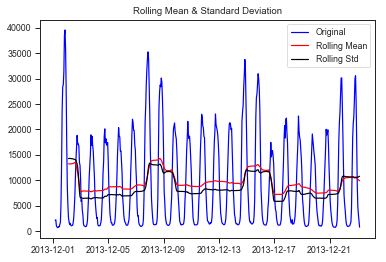

Results of Dickey-Fuller Test:
Test Statistic                  -3.608968
p-value                          0.005592
#Lags Used                      19.000000
Number of Observations Used    509.000000
Critical Value (1%)             -3.443263
Critical Value (5%)             -2.867235
Critical Value (10%)            -2.569803
dtype: float64


In [46]:
test_stationarity(TS_5161)

#### Comments & observations

From the above fig, we can see there is small variation in the rolling values of mean and standard deviation and there is not specific continously increasing or decreasing trend. This is more of visual technique to check whether time series is stationary or not from graph. 

To verify, we can use Dickey-Fuller test results, Test statistic & Critical values for different confident intervals. Here, the Test static (-3.60) is smaller than 1% Critical values. Therefore, we can say with 99% confidence interval that this time series is stationary. Also, with the p-value is less than 0.05 so we reject the null hypothesis & confirms that the series is stationary.  

#### Decomposition

In this method, both trend and seasonality are modeled separately and remaning part of the series is returned.

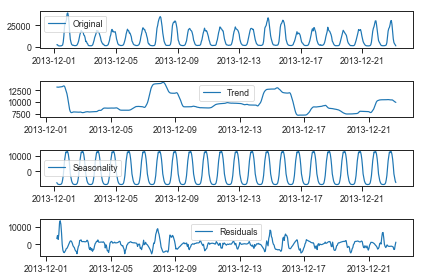

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(TS_5161)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ydata, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here, we can see Trend and Seasonality are seprated out of data. We can model our residuals. 

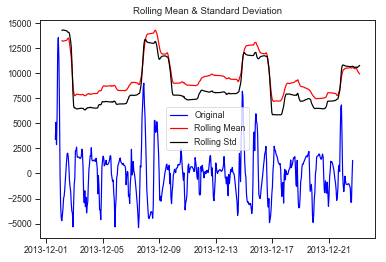

Results of Dickey-Fuller Test:
Test Statistic                -9.705228e+00
p-value                        1.046230e-16
#Lags Used                     1.500000e+01
Number of Observations Used    4.890000e+02
Critical Value (1%)           -3.443794e+00
Critical Value (5%)           -2.867469e+00
Critical Value (10%)          -2.569928e+00
dtype: float64


In [48]:
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

The Dickey-Fuller test also shows that the Test-Static value for residuals is also smaller than 1% Critical values. So, this time series is very close to stationary.

#### Eliminating Trend and Seasonality 

**Trend** can be removed by transformation. Here, we will take Log Transformation to elimininate the Trend. 

In [49]:
TS_5161_log = np.log(TS_5161)

Our time series has some daily **Seasonal** component, which can be removed. A time series where seasonal component has been removed is called seasonal stationary. 

There are different methods to correct seasonal component and eliminate seasonality : 

1. Difference: Taking the difference at a particular time lag 
2. Decomposition: Modelling both trend and seasonality and removing them from the model 

In our case, we have seasonal component at a lag of 24 hrs. 

Differencing : We can remove the seasonal component by subtracting the value from previous day. 

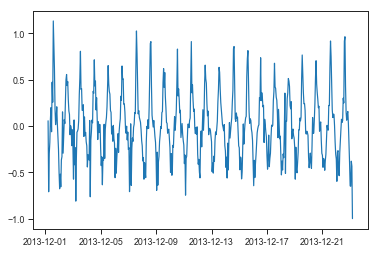

In [50]:
TS_5161_log_diff = TS_5161_log - TS_5161_log.shift()
plt.plot(TS_5161_log_diff)

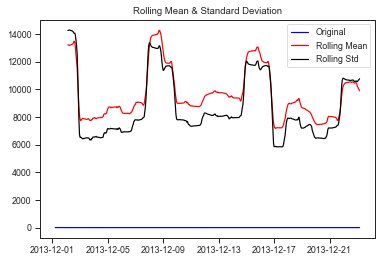

Results of Dickey-Fuller Test:
Test Statistic                -1.544001e+01
p-value                        2.873335e-28
#Lags Used                     1.900000e+01
Number of Observations Used    5.080000e+02
Critical Value (1%)           -3.443288e+00
Critical Value (5%)           -2.867246e+00
Critical Value (10%)          -2.569809e+00
dtype: float64


In [51]:
TS_5161_log_diff.dropna(inplace=True)
test_stationarity(TS_5161_log_diff)

Dickey-Fuller test statistic is less than the 1% Critical value.

### Forecasting the Time Series 

#### Ques. A self-contained description of the proposed algorithm

Here, we will be using **ARIMA** model as forecasting method.  

#### ACF and PACF  

These plots are basically used to determine the value of 'p' and 'q'

#### Plot ACF and PACF

With No Differencing 

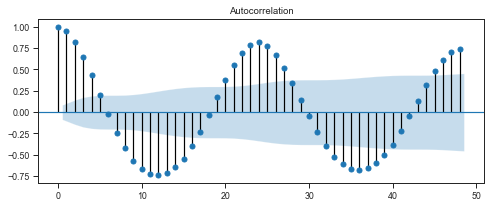

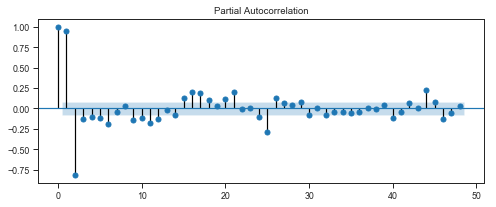

In [81]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf 

fig, ax = plt.subplots(figsize=(8,3))
plot_acf(TS_5161.dropna(),ax=ax,lags=48);

fig, ax =  plt.subplots(figsize=(8,3))
plot_pacf(TS_5161.dropna(),ax=ax,lags=48);

With Ist Order Differencing 

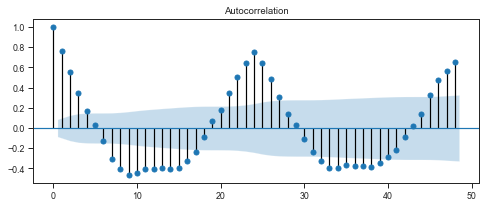

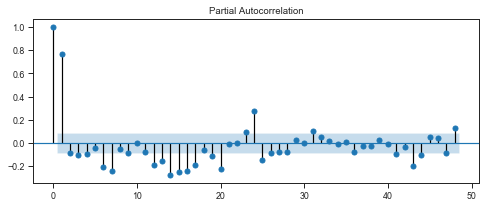

In [83]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf 

fig, ax = plt.subplots(figsize=(8,3))
plot_acf(TS_5161.diff().dropna(),ax=ax,lags=48);

fig, ax =  plt.subplots(figsize=(8,3))
plot_pacf(TS_5161.diff().dropna(),ax=ax,lags=48);

With IInd Order Differencing 

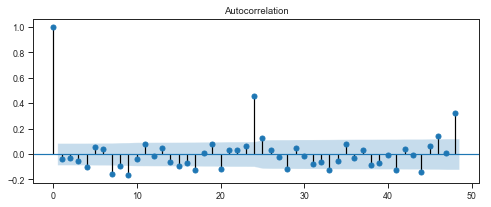

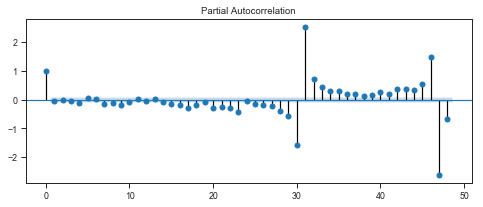

In [85]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf 

fig, ax = plt.subplots(figsize=(8,3))
plot_acf(TS_5161.diff().diff().dropna(),ax=ax,lags=48);

fig, ax =  plt.subplots(figsize=(8,3))
plot_pacf(TS_5161.diff().diff().dropna(),ax=ax,lags=48);

The right order of differencing is the minimum differencing required to get a near stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quickly.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.  

For the above timeseries, looking at the autocorrelation plot for the IInd order differencing the lag goes into far negative zone more quickly, which indicates, the series might be over differenced. Therefore, we should consider ACF and PACF plot with Ist order of differencing / Without differencing.  

AR term can be inspected by the PACF plot. We can observe, the PACF lag 1 and lag 2 is quite significant and is well above the significance line.  

MA term can be inspected by ACF plot.

PACF & ACF suggested that AR(2) and MA(2).

### Model Building 

As we know, we have a daily seasonality (with no specific trend) at every 24 hr period in the internet traffic activity. Therefore, we can either use **Auto-Arima or SARIMA (Seasonal Arima)**.

The advantage of using Auto-Arima over ARIMA is that after data preprocessing we can skip ACF and PACF steps for manually determining / inspecting AR and MA values. It uses the AIC (Akaike Information Criteria) and BIC (Bayesian Information Criteria) values generated by trying different combinations of p,d & q values to fit the model.  

### Auto-Arima 

#### Squareid 5161 (Area with the highest traffic in the four geographical areas)

In [197]:
df_5161.head()

,internet
datetime,
2013-12-01 04:00:00,2092.510257
2013-12-01 05:00:00,2210.605167
2013-12-01 06:00:00,1087.450661
2013-12-01 07:00:00,807.558327
2013-12-01 08:00:00,676.222631


In [198]:
df_5161.tail()

,internet
datetime,
2013-12-23 00:00:00,8987.801230
2013-12-23 01:00:00,4691.757804
2013-12-23 02:00:00,3207.742705
2013-12-23 03:00:00,2077.588679
2013-12-23 04:00:00,765.280927


In [138]:
### Train-Test split according to taskII

## Taking first 15 days of december as Training Set and 16-22 december week as Test set 

In [199]:
train = df_5161[df_5161.index < '2013-12-16 04:00:00']
test = df_5161[df_5161.index >= '2013-12-16 04:00:00']

In [200]:
train_internet_ts_log = np.log10(train['internet'])

In [172]:
### Performing Auto-Arima and Fit

#### Ques. Exact statistics on training and/or execution time of the algorithm for squareid 5161

In [201]:
import pmdarima as pm 
model = pm.auto_arima(df_5161, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=24,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,width_intercept=False)
output = model.fit(train_internet_ts_log)
print(output.summary().tables[0])
print(output.summary().tables[1])

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 24) (constant=True); AIC=9605.012, BIC=9622.096, Time=0.379 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=11147.825, BIC=11156.367, Time=0.012 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=9293.674, BIC=9310.758, Time=7.222 seconds
Near non-invertible roots for order (1, 0, 0)(1, 0, 0, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 24) (constant=True); AIC=10169.142, BIC=10186.226, Time=2.015 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=False); AIC=11546.010, BIC=11550.281, Time=0.008 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 0, 24) (constant=True); AIC=9225.148, BIC=9246.503, Time=4.390 seconds
Fit ARIMA: (1, 0, 1)x(2, 0, 0, 24) (constant=True); AIC=9196.634, BIC=9222.260, Time=17.768 seconds
Fit ARIMA: (1, 0, 1)x(2, 0, 1, 24) (constant=True); AIC=9224.871, BIC=9254.768, Time=19.106 secon

In [202]:
print(model.aic())

-882.3464064335773


In [203]:
forecast = output.predict(n_periods=169)

In [204]:
testCopy = test.copy()
testCopy['internet_ts_forecasted'] = np.power(10, forecast)

#### Accuracy Mertics (Squareid 5161)

In [241]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [206]:
mean_absolute_error(y_true=testCopy['internet'],
                   y_pred=testCopy['internet_ts_forecasted'])

1582.2498547464318

In [242]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [208]:
mean_absolute_percentage_error(y_true=testCopy['internet'],
                   y_pred=testCopy['internet_ts_forecasted'])

24.59779058911935

#### Comments and Observations: 

1. Around 24.59% MAPE implies that the model is about 75.41 % accurate in predicting the 16-22 week observations (squareid 5161). Although, this accuracy is not so good. 

2. Probably, this is because we have hourly dataset which exhibits multiple-seasonalities. For example, In a particular day, we can have intra-daily seasonalities as well as seasonality at every 24 hrs between previous and next day. Also, these can be different on weekdays and weekends. 

3. Generally, ARIMA does not handle multiple seasonalities quite well (https://stats.stackexchange.com/questions/360167/arima-model-configuration-for-hourly-forecasting-problem) 

#### Ques. Plot reporting the superposed time series of (i) the original traffic (ii) the predicted traffic in the week from December 16 to 22 (Squareid 5161) 

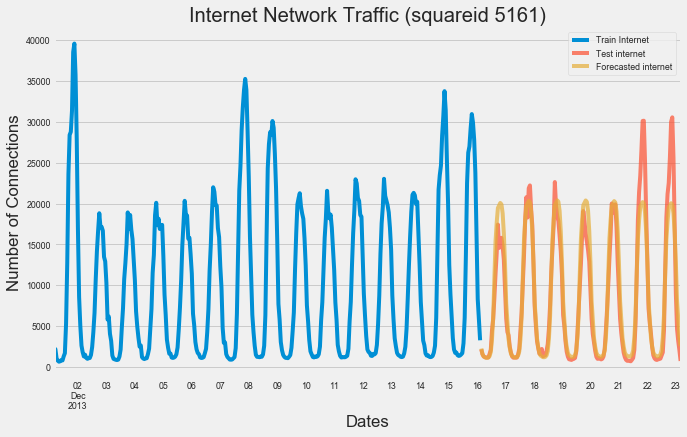

In [213]:
axis = train['internet'].plot(label='Train Internet', figsize=(10, 6))
testCopy['internet'].plot(ax=axis, label='Test internet', alpha=0.7)
testCopy['internet_ts_forecasted'].plot(ax=axis, label='Forecasted internet', alpha=0.7)
axis.set_xlabel('Dates')
axis.set_ylabel('Number of Connections')
plt.legend(loc='best')
plt.title('Internet Network Traffic (squareid 5161)')
plt.show()
plt.close()

#### Comments and Observations:  

1. From the graph, we can see Dates on x-axis and Number of internet connections made during the month of December 2013. 
2. The **BLUE line** belongs to network traffic for first 15 days used to train the model and **Red Line** belongs to network traffic used as test set for the week 16-22, December 2013. **Yellow line** belongs to forecasted value for that week. 
3. Here, it is clearly visible that the Auto-ARIMA model forcast is much closer to the actual pattern during the weekdays than weekends. 

#### Squareid 4159

In [284]:
df_4159 = df.loc[df['squareid'] == 4159]

In [285]:
df_4159 = df_4159[['internet']]

In [286]:
df_4159.head()

,internet
datetime,
2013-12-01 04:00:00,754.343807
2013-12-01 05:00:00,1296.067097
2013-12-01 06:00:00,1224.737176
2013-12-01 07:00:00,940.666652
2013-12-01 08:00:00,834.734766


In [287]:
df_4159.tail()

,internet
datetime,
2013-12-23 00:00:00,952.922963
2013-12-23 01:00:00,941.674240
2013-12-23 02:00:00,769.924011
2013-12-23 03:00:00,796.443202
2013-12-23 04:00:00,384.025582


In [288]:
### Train-Test split according to taskII

## Taking first 15 days of december as Training Set and 16-22 december week as Test set 

In [289]:
train = df_4159[df_4159.index < '2013-12-16 04:00:00']
test = df_4159[df_4159.index >= '2013-12-16 04:00:00']

In [290]:
train_internet_ts_log = np.log10(train['internet'])

In [252]:
### Performing Auto-Arima and Fit

#### Ques. Exact statistics on training and/or execution time of the algorithm for squareid 4159

In [291]:
import pmdarima as pm 
model = pm.auto_arima(df_4159, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=24,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,width_intercept=False)
output = model.fit(train_internet_ts_log)
print(output.summary().tables[0])
print(output.summary().tables[1])

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 24) (constant=True); AIC=7358.167, BIC=7375.250, Time=0.283 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=8783.560, BIC=8792.102, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=7136.111, BIC=7153.194, Time=4.852 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 24) (constant=True); AIC=7898.256, BIC=7915.340, Time=1.649 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=False); AIC=9528.730, BIC=9533.001, Time=0.008 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=7478.610, BIC=7491.423, Time=0.033 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 24) (constant=True); AIC=7131.793, BIC=7153.148, Time=26.428 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 1, 24) (constant=True); AIC=7140.115, BIC=7165.741, Time=12.612 seconds
Near non-invertible roots for order (1, 0, 0)(2, 0, 1, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit

In [292]:
print(model.aic())

-1080.4030119214083


In [293]:
forecast = output.predict(n_periods=169)

In [295]:
testCopy = test.copy()
testCopy['internet_ts_forecasted'] = np.power(10, forecast)

#### Accuracy Mertics (Squareid 4159)

In [296]:
mean_absolute_error(y_true=testCopy['internet'],
                   y_pred=testCopy['internet_ts_forecasted'])

390.9912635840451

In [297]:
mean_absolute_percentage_error(y_true=testCopy['internet'],
                   y_pred=testCopy['internet_ts_forecasted'])

30.660850518798444

#### Comments and Observation 

1. Around 30.66% MAPE implies that the model is about 69.39 % accurate in predicting the 16-22 week observations (squareid 4159). 

2. As, we saw earlier this squareid is near to squareid 4259 where famous Universities of Milan are present. There is high network traffic during weekdays than weekend and there is a lot of variability in network traffic. Also, as discussed earlier, we have hourly dataset which exhibits multiple-seasonalities. 

3. Generally, ARIMA does not handle multiple seasonalities quite well (https://stats.stackexchange.com/questions/360167/arima-model-configuration-for-hourly-forecasting-problem) 

#### Ques. Plot reporting the superposed time series of (i) the original traffic (ii) the predicted traffic in the week from December 16 to 22 (Squareid 4159) 

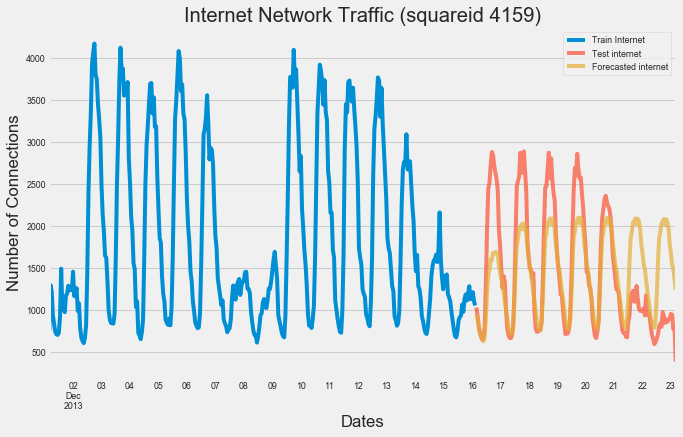

In [262]:
axis = train['internet'].plot(label='Train Internet', figsize=(10, 6))
testCopy['internet'].plot(ax=axis, label='Test internet', alpha=0.7)
testCopy['internet_ts_forecasted'].plot(ax=axis, label='Forecasted internet', alpha=0.7)
axis.set_xlabel('Dates')
axis.set_ylabel('Number of Connections')
plt.legend(loc='best')
plt.title('Internet Network Traffic (squareid 4159)')
plt.show()
plt.close()

#### Comments and Observations: 

1. From the graph, we can see Dates on x-axis and Number of internet connections made during the month of December 2013. 
2. The **BLUE line** belongs to network traffic for first 15 days used to train the model and **Red Line** belongs to network traffic used as test set for the week 16-22, December 2013. **Yellow line** belongs to forecasted value for that week. 
3. Here, it is clearly visible that there is a lot of variability in the network traffic. The traffic during the weekdays is much higher than weekends beacuse of Universities schedule. There is abrubt change in network traffic on weekdays following the weekends. Auto-ARIMA model is not able to capture those changes / differences.    

#### Squareid 4556

In [299]:
df_4556 = df.loc[df['squareid'] == 4556]

In [301]:
df_4556 = df_4556[['internet']]

In [302]:
df_4556.head()

,internet
datetime,
2013-12-01 04:00:00,3664.005609
2013-12-01 05:00:00,6282.915975
2013-12-01 06:00:00,4177.585841
2013-12-01 07:00:00,2335.108516
2013-12-01 08:00:00,1686.767064


In [303]:
df_4556.tail()

,internet
datetime,
2013-12-23 00:00:00,2659.106348
2013-12-23 01:00:00,2695.581511
2013-12-23 02:00:00,2948.995905
2013-12-23 03:00:00,2957.075679
2013-12-23 04:00:00,1310.584645


In [304]:
### Train-Test split according to taskII

## Taking first 15 days of december as Training Set and 16-22 december week as Test set 

In [305]:
train = df_4556[df_4556.index < '2013-12-16 04:00:00']
test = df_4556[df_4556.index >= '2013-12-16 04:00:00']

In [306]:
train_internet_ts_log = np.log10(train['internet'])

In [307]:
### Performing Auto-Arima and Fit

#### Ques. Exact statistics on training and/or execution time of the algorithm for squareid 4556

In [308]:
import pmdarima as pm 
model = pm.auto_arima(df_4556, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=24,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,width_intercept=False)
output = model.fit(train_internet_ts_log)
print(output.summary().tables[0])
print(output.summary().tables[1])

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 24) (constant=True); AIC=7911.920, BIC=7929.004, Time=0.372 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=8963.070, BIC=8971.612, Time=0.017 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=7768.917, BIC=7786.001, Time=5.084 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 24) (constant=True); AIC=8152.008, BIC=8169.092, Time=2.409 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=False); AIC=10065.413, BIC=10069.684, Time=0.008 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=8075.070, BIC=8087.883, Time=0.025 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 24) (constant=True); AIC=7756.598, BIC=7777.953, Time=28.300 seconds
Near non-invertible roots for order (1, 0, 0)(2, 0, 0, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 24) (constant=True); AIC=7721.771, BIC=7743.126, Time=3.496 seconds
Fi

In [309]:
print(model.aic())

-990.828022385116


In [310]:
forecast = output.predict(n_periods=169)

In [311]:
testCopy = test.copy()
testCopy['internet_ts_forecasted'] = np.power(10, forecast)

#### Accuracy Mertics (Squareid 4556) 

In [312]:
mean_absolute_error(y_true=testCopy['internet'],
                   y_pred=testCopy['internet_ts_forecasted'])

394.1276204081808

In [313]:
mean_absolute_percentage_error(y_true=testCopy['internet'],
                   y_pred=testCopy['internet_ts_forecasted'])

16.51351526538735

#### Comments and Observation 

1. Around 16.51% MAPE implies that the model is about 83.49 % accurate in predicting the 16-22 week observations (squareid 4159). This accuracy is more as compared to other squareids calculated above.     

2. As, we saw earlier the squareid is near to squareid 4456 which is present in city centre and one of the most famous nightlife places in the Milan city. There is high network traffic during evening hours. 

#### Ques. Plot reporting the superposed time series of (i) the original traffic (ii) the predicted traffic in the week from December 16 to 22 (Squareid 4556) 

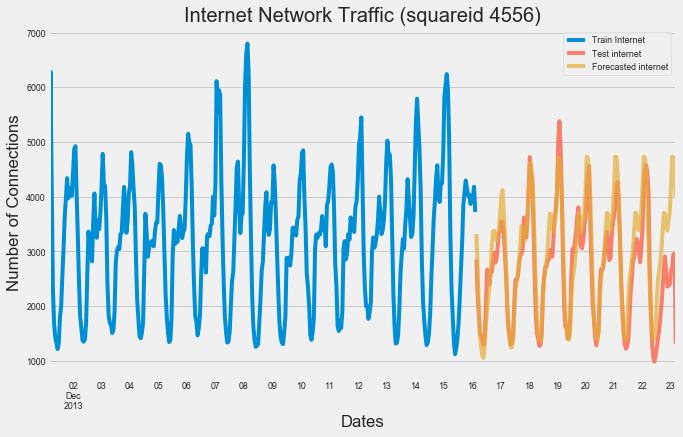

In [314]:
axis = train['internet'].plot(label='Train Internet', figsize=(10, 6))
testCopy['internet'].plot(ax=axis, label='Test internet', alpha=0.7)
testCopy['internet_ts_forecasted'].plot(ax=axis, label='Forecasted internet', alpha=0.7)
axis.set_xlabel('Dates')
axis.set_ylabel('Number of Connections')
plt.legend(loc='best')
plt.title('Internet Network Traffic (squareid 4556)')
plt.show()
plt.close()

#### Comments and Observations: 

1. From the graph, we can see Dates on x-axis and Number of internet connections made during the month of December 2013. 
2. The **BLUE line** belongs to network traffic for first 15 days used to train the model and **Red Line** belongs to network traffic used as test set for the week 16-22, December 2013. **Yellow line** belongs to forecasted value for that week. 
3. Here, We see some sharp peaks in the graph on each day repeatedly. This increase in traffic is during evening hours. Auto-ARIMA model is able to capture this pattern quite well.     

#### Squareid 5160

In [317]:
df_5160 = df.loc[df['squareid'] == 5160]

In [318]:
df_5160 = df_5160[['internet']]

In [319]:
df_5160.head()

,internet
datetime,
2013-12-01 04:00:00,753.050612
2013-12-01 05:00:00,1034.107291
2013-12-01 06:00:00,623.571441
2013-12-01 07:00:00,470.026165
2013-12-01 08:00:00,468.452390


In [320]:
df_4556.tail()

,internet
datetime,
2013-12-23 00:00:00,2659.106348
2013-12-23 01:00:00,2695.581511
2013-12-23 02:00:00,2948.995905
2013-12-23 03:00:00,2957.075679
2013-12-23 04:00:00,1310.584645


In [321]:
### Train-Test split according to taskII

## Taking first 15 days of december as Training Set and 16-22 december week as Test set 

In [322]:
train = df_5160[df_5160.index < '2013-12-16 04:00:00']
test = df_5160[df_5160.index >= '2013-12-16 04:00:00']

In [323]:
train_internet_ts_log = np.log10(train['internet'])

In [324]:
### Performing Auto-Arima and Fit

#### Ques. Exact statistics on training and/or execution time of the algorithm for squareid 5160

In [325]:
import pmdarima as pm 
model = pm.auto_arima(df_5160, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=24,
                           start_P=0,start_Q=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,width_intercept=False)
output = model.fit(train_internet_ts_log)
print(output.summary().tables[0])
print(output.summary().tables[1])

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 24) (constant=True); AIC=8590.639, BIC=8607.723, Time=0.238 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=10089.094, BIC=10097.636, Time=0.018 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=8342.584, BIC=8359.668, Time=8.208 seconds
Near non-invertible roots for order (1, 0, 0)(1, 0, 0, 24); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 24) (constant=True); AIC=9139.064, BIC=9156.148, Time=3.379 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=False); AIC=10558.222, BIC=10562.493, Time=0.007 seconds
Fit ARIMA: (1, 0, 1)x(1, 0, 0, 24) (constant=True); AIC=8298.375, BIC=8319.730, Time=8.709 seconds
Fit ARIMA: (1, 0, 1)x(2, 0, 0, 24) (constant=True); AIC=8227.722, BIC=8253.348, Time=23.317 seconds
Fit ARIMA: (1, 0, 1)x(2, 0, 1, 24) (constant=True); AIC=8174.428, BIC=8204.324, Time=21.358 seconds

In [326]:
print(model.aic())

-926.2338996897718


In [327]:
forecast = output.predict(n_periods=169)

In [328]:
testCopy = test.copy()
testCopy['internet_ts_forecasted'] = np.power(10, forecast)

#### Accuracy Mertics (Squareid 5160) 

In [329]:
mean_absolute_error(y_true=testCopy['internet'],
                   y_pred=testCopy['internet_ts_forecasted'])

888.3101280945076

In [330]:
mean_absolute_percentage_error(y_true=testCopy['internet'],
                   y_pred=testCopy['internet_ts_forecasted'])

22.415343181946394

#### Comments and Observations:

1. Around 22.41% MAPE implies that the model is about 77.59 % accurate in predicting the 16-22 week observations (squareid 5160).  

2. This squareid is near to the area(squareid 5161) with highest traffic during two month period. The model performed better for this squareid as compared to squareid 5161 because there is no surge in the Internet Network connections. Also, it is in the city centre of Milan. 

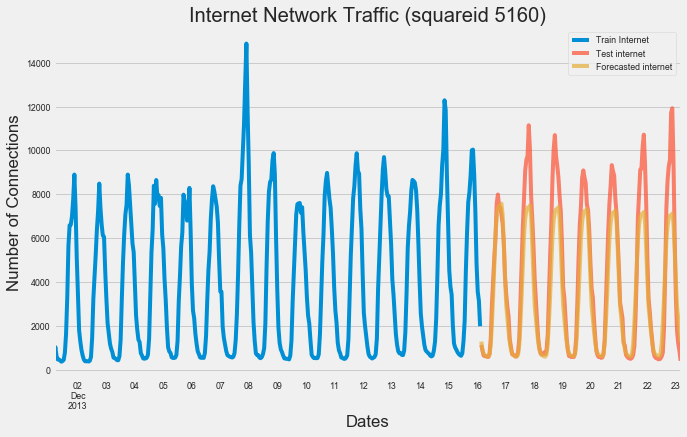

In [331]:
axis = train['internet'].plot(label='Train Internet', figsize=(10, 6))
testCopy['internet'].plot(ax=axis, label='Test internet', alpha=0.7)
testCopy['internet_ts_forecasted'].plot(ax=axis, label='Forecasted internet', alpha=0.7)
axis.set_xlabel('Dates')
axis.set_ylabel('Number of Connections')
plt.legend(loc='best')
plt.title('Internet Network Traffic (squareid 5160)')
plt.show()
plt.close()

#### Comments and Observations: 

1. From the graph, we can see Dates on x-axis and Number of internet connections made during the month of December 2013. 
2. The **BLUE line** belongs to network traffic for first 15 days used to train the model and **Red Line** belongs to network traffic used as test set for the week 16-22, December 2013. **Yellow line** belongs to forecasted value for that week. 
3. Here, the ARIMA model is able to capture internet network traffic where there are not much sharp peaks. The orginal internet traffic and number of connections made during first the 15 days of December 2013 is less as compared to the internet traffic during 16-22 week of december 2013. Auto-ARIMA model is not able to spot these surge in the network traffic and number of connections.     

#### Ques. Table reporting the mean absolute error (MSE) and mean absolute percentage error (MAPE) 

#### Auto-ARIMA Model 



|squareid | MSE | MAPE |
| ----- | ------ | ----- |
| 5161  |1582.24 | 24.59|
| 4159  |390.99 | 30.66|  
| 4556  |394.12|16.51|
| 5160  |888.31 |22.41|

### Conclusions: 

1. **Auto-ARIMA Model** gives better accuracy and able to capture the patterns in the areas / squareid where there is less sudden increase/decrease in the Internet network traffic.
2. Squareid 4556: Model performs best and has better accuracy score on Internet network traffic.
3. Squareid 4159: Model performs worst in this case beacuse there is sudden drop in the Internet network traffic and number of connections during the weekends. 

#### Some interesting follow up to explore / Personal recommendations:  

1. **Enrich prediction by adding some more features**: Explore more possibilities to incorporate more features/variables such as national holidays, holidays periods (Ex. Christmas & New Year holidays), events etc. 
2. **Make model self-learning**: Let the model learn from it's past mistakes in prediction and update it with new observations without rerunning the entire model. 
3. **Develop seprate model for weekdays and weekends**: It can be valuable to develop a seprate prediction model for the weekdays and weekends in particular, as we know there is a major difference in internet network traffic during the weekdays and weekends in some squareids.
4. **Prediction with other Time Series, Machine Learning and Deep Learning Models**: Finally, it can be interesting to run some state of the art time series, machine learning and deep learning models such as facebook/prophet, XGBoost, ADABoost, GluonTS (Introduced by AWS recently) on this dataset.  